/tmp/ipykernel_2515/3830791130.py:99: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[k+1,1] = x[k,1] + (3*g/(2*l)*x[k,0] + 3/(m * l**2)*u[k]) * dt


stopped at 7/41 -1.0260563426367189 -4.360174795336914


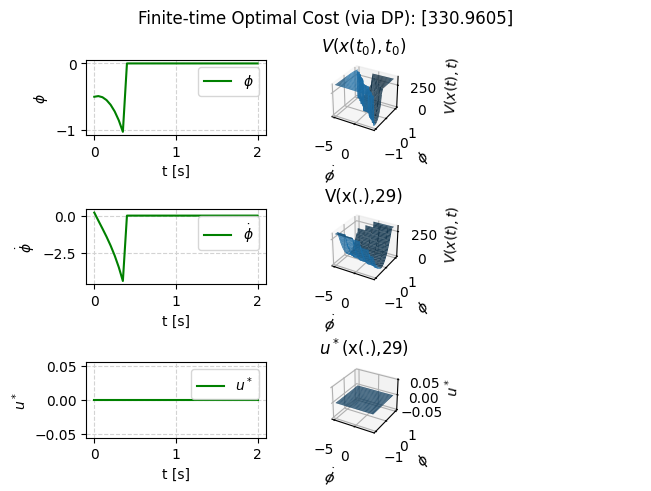

In [4]:
#!/usr/bin/python3
# DDP - Value Iteration
import numpy as np
import bisect as bi
from mpl_toolkits import mplot3d
import matplotlib.pyplot as pt
pt.rcdefaults()
pt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif",
    "mathtext.fontset": "dejavusans",
    "figure.constrained_layout.use": True
})
pt.close()
fig, ax = pt.subplots(3,3)

# Helpers %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
def edInt(a,s,b):
    return np.linspace(a,b,int(np.round((b-a)/s)) + 1)

# Used for poorman's nearest-neighbour regular-grid interpolation
def idx(aList, val):
    i = bi.bisect(aList, val) # right
    if i <= 0: # first
        pass
    elif len(aList) == i: # last
        i -= 1
    elif val - aList[i-1] < aList[i] - val: # left
        i -= 1
    return i

def lookup(aList, vals): # inefficient
    """vals is sorted"""
    indices = []
    v = vals
    if type(v) in [int,float,np.float64]:
        v = [v]
    for k in np.sort(v):
        indices.append(idx(aList,k))
    return np.array(indices, dtype=np.uint32)

# Settings %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
t0 = 0; dt = 0.05; tf = 1.5; infStValInc = 1000; nullCtr = 0
du = 2; dphi = 0.1; dphidot = 0.05
T = edInt(t0, dt, 2.0) 
U = edInt(-30, du, 2)
phi_vec = edInt(-1, dphi, 1)
phidot_vec = edInt(-5, dphidot, 4)
Phi, Phidot = np.meshgrid(phi_vec, phidot_vec)

g = 9.81 # [m/s^2]
l = 3*g/(2*21.5) # [m]
m = 3/(0.6 * l**2) # [kg]
q11 = 1; q22 = 1
R = 1
x0 = np.array([-0.5, 0.2]) 
N = T.size
V = np.zeros((Phidot.shape[0], Phi.shape[1], N)) 
u_opt = V.copy()
V[:,:,lookup(T, tf)[0]] = 300 * Phi[:,:]**2 
errPhi = np.zeros((Phidot.shape[0], Phi.shape[1]))
errPhidot = errPhi.copy()
depth=0 

# Algorithm  %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
for k in range(lookup(T, tf)[0], depth, -1):
    for i in range(0, Phidot.shape[0]):
        for j in range(0, Phi.shape[1]):
            L = (q11 * Phi[i,j]**2 + q22 * Phidot[i,j]**2 + R * U**2) * dt
            newPhi = Phi[i,j] + Phidot[i,j] * dt
            newPhidot = Phidot[i,j] + (3*g/(2*l)*Phi[i,j] + 3/(m * l**2)*U) * dt
            
            i_newPhi = lookup(phi_vec, newPhi)
            i_newPhidot = lookup(phidot_vec, newPhidot)
            
            errPhi[i,j] = np.mean(newPhi)
            errPhidot[i,j] = np.max(newPhidot)
            
            if (i_newPhi.size != 0 and i_newPhidot.size != 0):
                cost_to_go = L + V[i_newPhidot, i_newPhi, k]
                best_idx = np.argmin(cost_to_go)
                u_opt[i,j,k-1] = U[best_idx]
                V[i,j,k-1] = cost_to_go[best_idx]
            else:
                u_opt[i,j,k-1] = nullCtr
                V[i,j,k-1] = V[i,j,k] + infStValInc

# Simulation (from x0 using u_opt) %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
x = np.zeros((T.size,2))
x[0,:] = x0
u = np.zeros((T.size,1))
for k in range(0,T.size-1):
    if not(x[k,0]>=phi_vec[0] and x[k,0]<=phi_vec[-1]
           and x[k,1]>=phidot_vec[0] and x[k,1]<=phidot_vec[-1]):
        print(f'stopped at {k}/{T.size}', x[k,0], x[k,1])
        break
    u[k] = u_opt[lookup(phidot_vec, x[k,1]), lookup(phi_vec, x[k,0]), k]
    x[k+1,0] = x[k,0] + x[k,1] * dt
    x[k+1,1] = x[k,1] + (3*g/(2*l)*x[k,0] + 3/(m * l**2)*u[k]) * dt

# Visualisation %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Vx0 = V[lookup(phidot_vec, x0[1]), lookup(phi_vec, x0[0]), 0]
invalPhi = 100 * np.where(np.logical_or(errPhi[:,:] > phi_vec[-1], errPhi[:,:] < phi_vec[0]))[0].size \
    / (Phi.size)
invalPhidot = 100 * np.where(np.logical_or(errPhidot[:,:] > phidot_vec[-1], errPhidot[:,:] < phidot_vec[0]))[0].size \
    / (Phi.size)
           
ax[0,0].plot(T, x[:,0], 'g-', label=r'$\phi$')
ax[0,0].set(xlabel=r't [s]', ylabel=r'$\phi$')
ax[1,0].plot(T, x[:,1], 'g-', label=r'$\dot\phi$')
ax[1,0].set(xlabel=r't [s]', ylabel=r'$\dot\phi$')
ax[2,0].plot(T, u, 'g-', label=r'$u^*$')
ax[2,0].set(xlabel=r't [s]', ylabel=r'$u^*$')

ax1 = fig.add_subplot(3,3,2, projection='3d')
ax1.plot_surface(Phidot, Phi, V[:,:,0])
ax1.set(xlabel=r'$\dot\phi$', ylabel=r'$\phi$', zlabel=r'$V(x(t),t)$', title=r'$V(x(t_0),t_0)$')

kp = lookup(T, tf)[0] - 1
ax2 = fig.add_subplot(3,3,5, projection='3d')
ax2.plot_surface(Phidot, Phi, V[:,:,kp])
ax2.set(xlabel=r'$\dot\phi$', ylabel=r'$\phi$', zlabel=r'$V(x(t),t)$', title=f'V(x(.),{kp})')

ax3 = fig.add_subplot(3,3,8, projection='3d')
ax3.plot_surface(Phidot, Phi, u_opt[:,:,kp])
ax3.set(xlabel=r'$\dot\phi$', ylabel=r'$\phi$', zlabel=r'$u^*$', title=f'$u^*$(x(.),{kp})')

for i in range(ax.shape[0]):
    ax[i,0].grid(color='lightgray', linestyle='--')
    ax[i,0].legend()
    ax[i,1].axis('off')
    ax[i,2].axis('off')
fig.suptitle(f'Finite-time Optimal Cost (via DP): {Vx0}')
pt.show()